In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
url_train = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/train.csv'
url_val = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/val.csv'
url_test = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/test.csv'

df_train = pd.read_csv(url_train, index_col=0)
df_val = pd.read_csv(url_val, index_col=0)
df_test = pd.read_csv(url_test, index_col=0)

In [3]:
class DataWindow:
    def __init__(self, input_width, label_width, shift, df_train, df_val, df_test, label_columns=None):
        # window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        # データ
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        
        # ラベル
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(self.df_train.columns)}
        
        # スライス
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # ラベル開始位置
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, plot_col: str, model=None, max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        n_max = min(max_subplots, len(inputs))
        
        for n in range(n_max):
            plt.subplot(n_max, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='tab:green', s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='tab:red', s=64)
            
            if n == 0:
                plt.legend()
        plt.xlabel('Time (h)')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.df_train)
    
    @property
    def val(self):
        return self.make_dataset(self.df_val)
    
    @property
    def test(self):
        return self.make_dataset(self.df_test)
    
    @property
    def sample_batch(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [5]:
# for training
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(),
        metrics=[MeanAbsoluteError()]
    )
    history = model.fit(
        window.train,
        epochs=max_epochs,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

In [7]:
# models
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                res = inputs[:, :, index]
                res = res[:, :, tf.newaxis]
                tensors.append(res)
            return tf.concat(tensors, axis=-1)
        else:
            res = inputs[:, :, self.label_index]
            return res[:, :, tf.newaxis]

class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])
    
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

# 線形モデル
linear = Sequential([Dense(units=1)])
ms_linear = Sequential([Dense(units=1, kernel_initializer=tf.initializers.zeros)])
mo_linear = Sequential([Dense(units=2)])
# DNN
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])
ms_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

In [8]:
# シングルステップ
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
column_indices = {name: i for i, name in enumerate(df_train.columns)}
baseline_last = Baseline(column_indices['traffic_volume'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
test_performance = {}

## ベースライン
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
test_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)
## 線形モデル
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
test_performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
## DNN
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
test_performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

# マルチステップ
multi_window = DataWindow(input_width=24, label_width=24, shift=24, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_test_performance = {}

## ベースライン
ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_test_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test)
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_test_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test)
## 線形モデル
history = compile_and_fit(ms_linear, multi_window)
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_test_performance['Linear'] = ms_linear.evaluate(multi_window.test)
## DNN
history = compile_and_fit(ms_dense, multi_window)
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_test_performance['Dense'] = ms_dense.evaluate(multi_window.test)

# 多変数アウトプット
col_names = ['temp', 'traffic_volume']
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=col_names)
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=col_names)
mo_baseline_last = Baseline(label_index=[column_indices[col] for col in col_names])
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_test_performance = {}

## ベースライン
mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_single_step_window.val)
mo_test_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_single_step_window.val)
## 線形モデル
history = compile_and_fit(mo_linear, mo_single_step_window)
mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_test_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test)
## DNN
history = compile_and_fit(mo_dense, mo_single_step_window)
mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_test_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test)

110/110 [==============================] - 0s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831
Epoch 1/50
384/384 [==============================] - 2s 3ms/step - loss: 0.1478 - mean_absolute_error: 0.3296 - val_loss: 0.0949 - val_mean_absolute_error: 0.2637
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0575 - mean_absolute_error: 0.1931 - val_loss: 0.0423 - val_mean_absolute_error: 0.1688
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0287 - mean_absolute_error: 0.1313 - val_loss: 0.0253 - val_mean_absolute_error: 0.1276
Epoch 4/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0192 - mean_absolute_error: 0.1063 - val_loss: 0.0182 - val_mean_absolute_error: 0.1055
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0150 - mean_absolute_error: 0.0927 - val_loss: 0.0146 - val_mean_absolute_error: 0.0928
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0128

## リカレントニューラルネットワーク(RNN)を探索する

## LSTMアーキテクチャを調べる

## LSTMアーキテクチャを実装する

In [18]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
test_performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 8s 16ms/step - loss: 0.0316 - mean_absolute_error: 0.1258 - val_loss: 0.0108 - val_mean_absolute_error: 0.0755
Epoch 2/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0050 - val_mean_absolute_error: 0.0506
Epoch 3/50
384/384 [==============================] - 9s 24ms/step - loss: 0.0046 - mean_absolute_error: 0.0477 - val_loss: 0.0038 - val_mean_absolute_error: 0.0437
Epoch 4/50
384/384 [==============================] - 13s 34ms/step - loss: 0.0039 - mean_absolute_error: 0.0432 - val_loss: 0.0033 - val_mean_absolute_error: 0.0401
Epoch 5/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0034 - mean_absolute_error: 0.0401 - val_loss: 0.0030 - val_mean_absolute_error: 0.0382
Epoch 6/50
384/384 [==============================] - 8s 20ms/step - loss: 0.0032 - mean_absolute_error: 0.0383 - val_loss: 0.0028 - val_mean_absolute_error: 0.0370
Epoch 7/5

In [11]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
history = compile_and_fit(ms_lstm_model, multi_window)
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_test_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test)

Epoch 1/50
383/383 [==============================] - 9s 19ms/step - loss: 0.0504 - mean_absolute_error: 0.1617 - val_loss: 0.0206 - val_mean_absolute_error: 0.0996
Epoch 2/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0169 - mean_absolute_error: 0.0894 - val_loss: 0.0181 - val_mean_absolute_error: 0.0922
Epoch 3/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0153 - mean_absolute_error: 0.0837 - val_loss: 0.0170 - val_mean_absolute_error: 0.0870
Epoch 4/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0147 - mean_absolute_error: 0.0811 - val_loss: 0.0165 - val_mean_absolute_error: 0.0851
Epoch 5/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0143 - mean_absolute_error: 0.0798 - val_loss: 0.0161 - val_mean_absolute_error: 0.0831
Epoch 6/50
383/383 [==============================] - 8s 20ms/step - loss: 0.0140 - mean_absolute_error: 0.0787 - val_loss: 0.0157 - val_mean_absolute_error: 0.0826
Epoch 7/50

In [12]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=2)
])
history = compile_and_fit(mo_lstm_model, mo_wide_window)
mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_test_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test)

Epoch 1/50
384/384 [==============================] - 9s 20ms/step - loss: 0.0354 - mean_absolute_error: 0.1212 - val_loss: 0.0121 - val_mean_absolute_error: 0.0698
Epoch 2/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0073 - mean_absolute_error: 0.0555 - val_loss: 0.0051 - val_mean_absolute_error: 0.0450
Epoch 3/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0041 - mean_absolute_error: 0.0409 - val_loss: 0.0033 - val_mean_absolute_error: 0.0373
Epoch 4/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0031 - mean_absolute_error: 0.0354 - val_loss: 0.0026 - val_mean_absolute_error: 0.0328
Epoch 5/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0327 - val_loss: 0.0022 - val_mean_absolute_error: 0.0303
Epoch 6/50
384/384 [==============================] - 7s 19ms/step - loss: 0.0025 - mean_absolute_error: 0.0308 - val_loss: 0.0020 - val_mean_absolute_error: 0.0289
Epoch 7/50

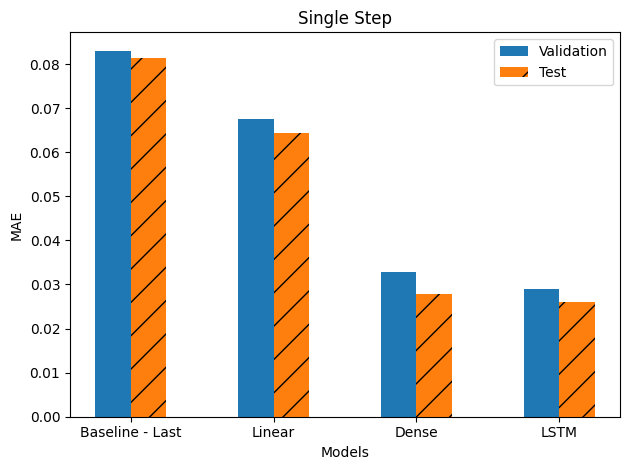

In [19]:
# single stepの結果比較
plt.title('Single Step')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(val_performance.keys(), [v[1] for v in val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(test_performance.keys(), [v[1] for v in test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.legend()
plt.tight_layout()

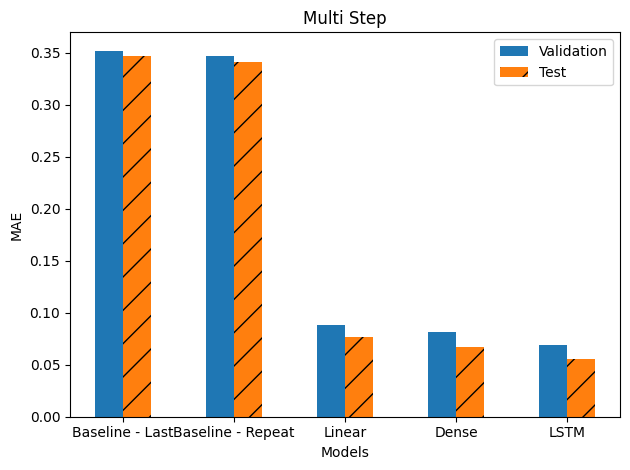

In [14]:
# multi stepの結果比較
plt.title('Multi Step')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(ms_val_performance.keys(), [v[1] for v in ms_val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(ms_test_performance.keys(), [v[1] for v in ms_test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.legend()
plt.tight_layout()

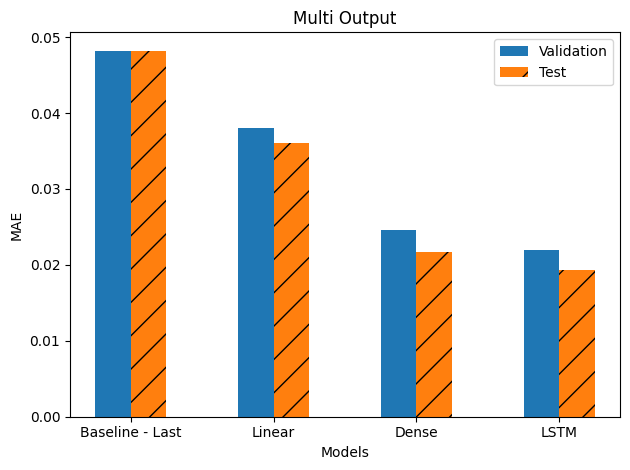

In [15]:
# multi outputの結果比較
plt.title('Multi Output')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(mo_val_performance.keys(), [v[1] for v in mo_val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(mo_test_performance.keys(), [v[1] for v in mo_test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.legend()
plt.tight_layout()